In [109]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import colors
import cv2

***Show the Image***

In [110]:
def show_image_plt(img_rgb):
    plt.imshow(img_rgb)
    plt.show()


def show_image(img):
    cv2.imshow("Image", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

***height (rows), width(cols)***

In [111]:
def resize_to_square(vegi_bgr):
    if vegi_bgr.shape[0] == 256 and vegi_bgr.shape[1] == 256:
        return vegi_bgr
    
    img_size = 256
    height, width = vegi_bgr.shape[:2]
    a1 = width / height
    a2 = height / width

    if (a1 > a2):
        r_img = cv2.resize(vegi_bgr, (round(img_size * a1), img_size), interpolation = cv2.INTER_AREA)
        margin = int(r_img.shape[1]/6)
        resized_img = r_img[0:img_size, margin:(margin+img_size)]

    elif(a1 < a2):
        # if height greater than width
        r_img = cv2.resize(vegi_bgr, (img_size, round(img_size * a2)), interpolation = cv2.INTER_AREA)
        margin = int(r_img.shape[0]/6)
        resized_img = r_img[margin:(margin+img_size), 0:img_size]

    elif(a1 == a2):
        # if height and width are equal
        r_img = cv2.resize(vegi_bgr, (img_size, round(img_size * a2)), interpolation = cv2.INTER_AREA)
        resized_img = r_img[0:img_size, 0:img_size]

    if(resized_img.shape[0] != img_size or resized_img.shape[1] != img_size):
        resized_img = r_img[0:img_size, 0:img_size]

    return resized_img

In [112]:
def print_color_values(img, shape_row=(0, 50), shape_col=(0, 60)):
    for row in range(shape_row[0], shape_row[1]):
        for col in range(shape_col[0], shape_col[1]):
            print(f"Row {row}: Spalte {col} Pixel: {img[row, col]}")

https://realpython.com/python-opencv-color-spaces/

The Code below is for data augmentation. It is a technique for enlarging a dataset.
It will use the standard techniques like horizontal & vertical flipping and rotation.

Load Images from personal cloud storage

Applying the median filter https://theailearner.com/tag/cv2-medianblur/

https://machinelearningknowledge.ai/image-segmentation-in-python-opencv/

https://docs.opencv.org/4.x/de/d62/tutorial_bounding_rotated_ellipses.html

Approach: https://stackoverflow.com/questions/72100376/opencv-how-to-draw-a-rotated-bounding-box-in-python

compute dynamically thresholds: https://stackoverflow.com/questions/24862374/canny-edge-detector-threshold-values-gives-different-result

In [113]:
#path = "G:\Meine Ablage\KI_Projekt\Bilder\Zwiebel\zwiebel_9.jpg"
#vegi = cv2.imread(path.replace("\\","/")) # As BGR

def draw_contours(bgr_img, object_area):
    #gray = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV)
    hue, saturation, value = cv2.split(hsv)
    #print("sat")
    #show_image_plt(saturation)
    blurred_sat = cv2.GaussianBlur(saturation, (3, 3), 0)
    #print("gray after blur")
    #plt.imshow(blurred_sat, cmap='gray')
    #plt.show()
    # Thresh 50 - 100
    # Or from 85 - 100 removes some more small edges
    # Thresh from 120 only shows the edge from vegi: karotte_107.jpg"
    # Compute the thresh dynamically from the mean() value. 
    thresh = blurred_sat.mean()
    # *****
    std = blurred_sat.std()
    thresh_low = thresh - std
    thresh_high = thresh + std
    # The factors were simply selected by testing the algoritm. Another approach could be to calculate the mean with the standard deviation -> Test it ???
    #thresh_low = 0.3 * thresh 
    #thresh_high = 2 * thresh
    
    #print(f"Thresh low: {thresh_low} and Thresh high: {thresh_high}")
    # The next four lines control how good the bounding box will fit
    edges = cv2.Canny(blurred_sat, thresh_low, thresh_high)
    #print("EDGES CANNY")
    #show_image_plt(edges)
    kernel = np.ones((4, 4), np.uint8) # creates 4x4 Identity matrix

    # To see the effect if changing kernel and iterations plot it. It seems if the value is to small than the probabillity is higher that the edge lines are not closed
    dilate = cv2.dilate(edges, kernel, iterations=4)
    #print("DILATE") 
    #show_image_plt(dilate)

    erode = cv2.erode(dilate, kernel, iterations=4)
    #show_image_plt(erode)
    
    contours, hierarchy = cv2.findContours(erode, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
    #print(f"Lenght Contours: {len(contours)}")
    bgr_img_copy = bgr_img.copy()
    # Flag makes sure that there is a maximum of 1 box in each image. Assumption, the bounding box for the vegi is always the biggest
    more_than_one_box = False
    for i, contour in enumerate(contours):
        
        area = cv2.contourArea(contour)
        if area >= object_area:
            rect = cv2.minAreaRect(contour)
            box = cv2.boxPoints(rect)
            box = np.intp(box)
            cv2.drawContours(bgr_img_copy, [box], 0, (0, 255, 0), 2)
            
            # Ellipse
            #ellipse = cv2.fitEllipse(contour)
            #cv2.ellipse(bgr_img_copy, ellipse, (255, 255, 0), 2, cv2.LINE_AA)

            # Calculate Circularity
            perimeter = cv2.arcLength(contour, True)
            r_circle = perimeter / (2 * np.pi)
            A_circle = r_circle**2 * np.pi
            circularity = area / A_circle
            
            #circularity = (4 * np.pi * area) / (perimeter ** 2)
            #print(f"Perimeter: {perimeter}  /// Circularity: {circularity}")
            #print("Draw Contour")
            if i > 0:
                # There are more than 2 boxes in the image
                more_than_one_box = True
    
    rgb = cv2.cvtColor(bgr_img_copy, cv2.COLOR_BGR2RGB)
    
    return rgb, more_than_one_box, box, rect, area, circularity

def get_size_box(box):
    x0 = box[0][0]
    y0 = box[0][1]
    x1 = box[1][0]
    y1 = box[1][1]

    x2 = box[2][0]
    y2 = box[2][1]

    l0_1 = round(((x0 - x1)**2 + (y0 - y1)**2)**0.5, 2)
    l1_2 = round(((x1 - x2)**2 + (y1 - y2)**2)**0.5, 2)

    w = min(l0_1, l1_2)
    h = max(l0_1, l1_2)

    return h, w

def crop_minAreaRect(img_BGR, rect, h, w):
    
    pic = img_BGR.copy()
    # rotate img
    angle = rect[2]
    rows,cols = img_BGR.shape[0], img_BGR.shape[1]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    img_rot = cv2.warpAffine(img_BGR,M,(cols,rows))
    
    
    # rotate bounding box
    rect0 = (rect[0], rect[1], 0.0) 
    box = cv2.boxPoints(rect0)
    box = np.intp(box)
    #print("BOX:", box)
    cv2.drawContours(img_rot, [box], 0, (255, 255, 255), 1) # white frame
    #print("BGR DRAW BOX INTO ROTATED")
    #show_image_plt(img_rot)
    #pts = np.int0(cv2.transform(np.array([box]), M))[0]    
    #pts[pts < 0] = 0

    #print("TRANSFORMED BOX: ", pts)
    w_rect = int(rect[1][0])
    h_rect = int(rect[1][1])

    # crop
    box = np.clip(box, a_min=0, a_max=None)

    img_crop_BGR = img_rot[box[1][1]:box[1][1]+h_rect, box[1][0]:box[1][0]+w_rect]

    #img_crop = img_rot[pts[1][1]:pts[0][1], 
    #                   pts[1][0]:pts[2][0]]#

    return img_crop_BGR

def is_box_rotated(box):
    # If the box is not rotated then the top left corner should be the first element in box array
    x0, y0 = box[0][0], box[0][1]
    y1 = box[1][1]
    x3 = box[3][0]
    
    if y0 == y1 and x0 == x3:
        # box is not rotated
        return False
    # BOX IS ROTATED
    return True

def get_color(rgb_segment):
    cropped_vegi_2D = rgb_segment.reshape((-1,3))
    # convert to np.float32
    cropped_vegi_2D = np.float32(cropped_vegi_2D)

    # define criteria and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1)
    ret, label, center = cv2.kmeans(cropped_vegi_2D, 2, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    center = np.uint8(center)
   
    res = center[label.flatten()]
    res2 = res.reshape((rgb_segment.shape))
    
    #returns center in rgb format
    return center, ret, label

def mask_green(cropped_vegi_seg_rgb, lower_thresh=(30, 175, 25), higher_thresh=(100, 255, 255)):
    ## Convert to HSV
    cropped_vegi_seg_hsv = cv2.cvtColor(cropped_vegi_seg_rgb, cv2.COLOR_RGB2HSV)

    ## Mask of green (36,25,25) ~ (86, 255,255)
    # mask = cv2.inRange(hsv, (36, 25, 25), (86, 255,255))
    mask = cv2.inRange(cropped_vegi_seg_hsv, lower_thresh, higher_thresh)
    
    ## Slice the green
    imask = mask>0
    green_rgb = np.zeros_like(cropped_vegi_seg_rgb, np.uint8)
    green_rgb[imask] = cropped_vegi_seg_rgb[imask]

    return green_rgb, imask

    #Image as BGR
def segment_img_2(cropped_vegi_bgr):
    #img must be BGR
    gray = cv2.cvtColor(cropped_vegi_bgr, cv2.COLOR_BGR2GRAY)

    ret, thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY_INV +cv2.THRESH_OTSU)


    #kernel = np.ones((3, 3), np.uint8)
    #closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE,kernel, iterations = 15)
    #bg = cv2.dilate(closing, kernel, iterations = 1)
    #dist_transform = cv2.distanceTransform(closing, cv2.DIST_L2, 0)
    #ret, fg = cv2.threshold(dist_transform, 0.02*dist_transform.max(), 255, 0)

    return thresh

def color_from_segmented_binary(seg_bin, cropped_vegi_bgr):
    imask = seg_bin>0 #False / True array
    segment = np.zeros_like(cropped_vegi_bgr, np.uint8)
    segment[imask] = cropped_vegi_bgr[imask] #BGR

    segment_rgb = cv2.cvtColor(segment, cv2.COLOR_BGR2RGB) #RGB

    return segment_rgb

def keep_object_remove_green(mask, cropped_vegi_seg_rgb):
    inverted_mask = np.invert(mask)
    inverted_green_rgb = np.zeros_like(cropped_vegi_seg_rgb, np.uint8)
    inverted_green_rgb[inverted_mask] = cropped_vegi_seg_rgb[inverted_mask]
    
    return inverted_green_rgb

def count_green_pixels(binary_green_mask):
    #only count True boolean. These are my green pixels
    return binary_green_mask.sum()
    

def sift(img_bgr):
    gray_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)  # 256 x 256
    sift = cv2.SIFT_create(65536)
    kp, _ = sift.detectAndCompute(gray_img, None)
    #img = cv2.drawKeypoints(gray_img, kp, None, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    total = 0
    for key in kp:
        total += key.size
    mean = total / len(kp)

    return len(kp), mean

def crop_roi(img_bgr, box):
    left_point, top_point = np.min(box, axis=0) # left point = x coordiante, top point y coordinate could be from different points ! 
    right_point, bottom_point = np.max(box, axis=0)
   
    #new width and height
    if top_point < 0:
        top_point = 0

    if left_point < 0:
        left_point = 0

    if right_point > 256:
        right_point = 256

    if bottom_point > 256:
        bottom_point = 256

    h_new = bottom_point - top_point #rows
    w_new = right_point - left_point #cols

    new_top_left_point = np.array([left_point, top_point])

    new_crop = img_bgr[new_top_left_point[1]:new_top_left_point[1]+h_new, new_top_left_point[0]:new_top_left_point[0]+w_new]
   
    return new_crop

In [114]:
def debug_color(only_green_rgb): # binary mask
    #only_green_rgb =  cv2.cvtColor(only_green, cv2.COLOR_GRAY2RGB)
    only_green_hsv =  cv2.cvtColor(only_green_rgb, cv2.COLOR_RGB2HSV)
    plt.imshow(only_green_hsv)
    plt.show()

    h, s, v = cv2.split(only_green_hsv)
    h_1d = h.flatten()
    s_1d = s.flatten()
    v_1d = v.flatten()

    h_mean_counter = 0
    v_mean_counter = 0
    s_mean_counter = 0
    sum_h = 0
    sum_v = 0
    sum_s = 0
    for i in range(0, h_1d.shape[0]):
        if h_1d[i] > 1:
            sum_h += h_1d[i]
            h_mean_counter += 1

        if v_1d[i] > 1:
            sum_v += v_1d[i]
            v_mean_counter += 1

        if s_1d[i] > 1:
            sum_s += s_1d[i]
            s_mean_counter += 1

    mean_h = int(sum_h / h_mean_counter)
    mean_v = int(sum_v / v_mean_counter)
    mean_s = int(sum_s / s_mean_counter)

    print(f"H: {mean_h} / S: {mean_s} / V: {mean_v} ")
    print(h_mean_counter, s_mean_counter, v_mean_counter)

    hsv = [mean_h, mean_s, mean_v]
    rgb = cv2.cvtColor( np.uint8([[hsv]] ), cv2.COLOR_HSV2RGB)[0][0]
    print("RGB: ", rgb)

def segment_potato_tribes(cropped_bgr):
    cropped_gray = cv2.cvtColor(cropped_bgr, cv2.COLOR_BGR2GRAY)
    #print("Cropped Gray")
    #show_image_plt(cropped_gray)
    thresh_low = 100
    thresh_high = 150
    edges = cv2.Canny(cropped_gray, thresh_low, thresh_high)
    print("Edges Gray")
    show_image_plt(edges)

    contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    gray_img_copy = cropped_gray.copy()
    # Flag makes sure that there is a maximum of 1 box in each image. Assumption, the bounding box for the vegi is always the biggest
    more_than_one_box = False
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
     
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.intp(box)
        cv2.drawContours(gray_img_copy, [box], 0, (0, 255, 0), 1)
    
    plt.imshow(gray_img_copy, cmap="gray")
    plt.show()
    

def get_contours(bgr_img, object_area=500):
    #gray = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV)

    hue, saturation, value = cv2.split(hsv)
    
    blurred_sat = cv2.GaussianBlur(saturation, (7, 7), 0)
    #show_image_plt(blurred_sat)
    # Thresh 50 - 100
    # Or from 85 - 100 removes some more small edges
    # Thresh from 120 only shows the edge from vegi: karotte_107.jpg"
    # Compute the thresh dynamically from the mean() value. 
    thresh = blurred_sat.mean()
    # *****
    std = blurred_sat.std()
    thresh_low = thresh - std
    thresh_high = thresh + std
    # The factors were simply selected by testing the algoritm. Another approach could be to calculate the mean with the standard deviation -> Test it ???
    #thresh_low = 0.3 * thresh 
    #thresh_high = 2 * thresh
    
    #print(f"Thresh low: {thresh_low} and Thresh high: {thresh_high}")
    # The next four lines control how good the bounding box will fit
    edges = cv2.Canny(blurred_sat, thresh_low, thresh_high)
    show_image_plt(edges)
    kernel = np.ones((4, 4), np.uint8) # creates 4x4 Identity matrix

    # To see the effect if changing kernel and iterations plot it. It seems if the value is to small than the probabillity is higher that the edge lines are not closed
    dilate = cv2.dilate(edges, kernel, iterations=4) 

    erode = cv2.erode(dilate, kernel, iterations=4)

    contours, hierarchy = cv2.findContours(erode, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10] # ???
   
    bgr_img_copy = bgr_img.copy()
    # Flag makes sure that there is a maximum of 1 box in each image. Assumption, the bounding box for the vegi is always the biggest
    more_than_one_box = False
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area >= object_area:
            rect = cv2.minAreaRect(contour)
            box = cv2.boxPoints(rect)
            box = np.intp(box)
            cv2.drawContours(bgr_img_copy, [box], 0, (0, 255, 0), 2)

            # Ellipse
            ellipse = cv2.fitEllipse(contour)
            cv2.ellipse(bgr_img_copy, ellipse, (255, 255, 0), 2, cv2.LINE_AA)

            # Circle
            circle_center, radius = cv2.minEnclosingCircle(contour)  # circle center (x,y)
            circle_center_int = int(circle_center[0]), int(circle_center[1])
            print("center: ", circle_center[0], type(circle_center_int[0]), "radius",type(radius), radius)
            cv2.circle(bgr_img_copy, circle_center_int, int(radius), (255, 0, 0), 1)
            #perimeter = cv2.arcLength(contour, True) Umfang
            #circularity = (4 * np.pi * area) / (perimeter ** 2)
            #print(f"Perimeter: {perimeter}  /// Circularity: {circularity}")
            #print("Draw Contour")
        print("I: ", i)

    rgb_img_copy = cv2.cvtColor(bgr_img_copy, cv2.COLOR_BGR2RGB)
    return rgb_img_copy, contours

Load images from storage and pass them through the preprocessing pipeline. The individual steps are:<br>
- Read Image as BGR Format<br>
- Resize Image to square format<br>
- Draw bounding box around the object in the image and convert it to RGB<br>
- get Hight and Width from the bounding box<br>
- check If the box is rotated and depending on that crop the area of the bounding box out of the image<br>
- Do Object Segmentation on the cropped image and return the binary segmented img (mask)<br>
- Get the segmented cropped RGB image<br>
- Place a green mask on the segmented cropped RGB image and get only the green pixels<br>
- Calculate the color from the segmented cropped RGB image with kmeans algorithm. Set k=2<br>
- Write the desired features to the dataframe

In [115]:
folders = ["Kartoffel", "Karotte", "Zwiebel", "Karotte_Trieb", "Zwiebel_Trieb", "Kartoffel_Trieb"]
#folders = ["Internet"]
paths = []
for fold in folders:
    for fname in os.listdir(f"G:/Meine Ablage/KI_Projekt/Bilder/{fold}"):
        paths.append(f"G:/Meine Ablage/KI_Projekt/Bilder/{fold}/{fname}")
        

In [119]:
paths

['G:/Meine Ablage/KI_Projekt/Bilder/Kartoffel/kartoffel_1.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Kartoffel/kartoffel_2.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Kartoffel/kartoffel_3.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Kartoffel/kartoffel_4.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Kartoffel/kartoffel_5.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Kartoffel/kartoffel_6.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Kartoffel/kartoffel_7.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Kartoffel/kartoffel_8.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Kartoffel/kartoffel_9.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Kartoffel/kartoffel_10.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Kartoffel/kartoffel_11.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Kartoffel/kartoffel_12.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Kartoffel/kartoffel_13.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Kartoffel/kartoffel_14.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilder/Kartoffel/kartoffel_15.jpg',
 'G:/Meine Ablage/KI_Projekt/Bilde

In [121]:
#folders = ["Kartoffel", "Karotte", "Zwiebel", "Karotte_Trieb", "Zwiebel_Trieb", "Kartoffel_Trieb"]
#folders = ["Kartoffel_Trieb"]
#folders = ["Zwiebel_Trieb", "Kartoffel_Trieb", "Karotte_Trieb"]
#paths = []
#for fold in folders:
#    lower = fold.lower()
#    for i in range(100, 105): #87, 91
#        paths.append(f"G:/Meine Ablage/KI_Projekt/Bilder/{fold}/{lower}_{i}.jpg")
#paths = ['G:/Meine Ablage/KI_Projekt/Bilder/Internet/zwiebel_2.jpg']
vegis_df = pd.DataFrame(columns=["Hight", "Width", "R", "G", "B", "green pixels", "green onion pixels", "ratio area", "circularity", "keypoints", "mean keypoints", "Label", "Image"])
debug_list = list()        
center_points = np.array([0, 0, 0])
ms = []
for i, path in enumerate(paths):
    #print(f"++++++++++++++++++++NEW IMAGE +++++++++++++++++++++++\n")
    if 'desktop.ini' in path:
        continue
    vegi_label = path.split("/")[4]
 
    #vegi_BGR = cv2.imread(path.replace("\\","/")) # As BGR
    vegi_BGR = cv2.imread(path) # As BGR
    vegi_sq_BGR_original = resize_to_square(vegi_BGR) # BGR
    
    ##################### CHANGE SAT COLOR SPACE ###########################
    #vegi_sq_HSV_orig = cv2.cvtColor(vegi_sq_BGR_original, cv2.COLOR_BGR2HSV)
    #h, s, v = cv2.split(vegi_sq_HSV_orig)
    #m = np.mean(s)
    #ms.append(m)
    #s_new = s * 0.5
    #hsv_img = cv2.merge([h, np.uint8(s_new), v])
    #vegi_sq_BGR_original = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2BGR)
    #show_image_plt(vegi_sq_BGR_original)

    ##################### END ##############################################

    try:
        vegi_with_box_rgb, more_than_one_box, box, rect, area, circularity = draw_contours(vegi_sq_BGR_original, object_area=500)
        if more_than_one_box:
            box_size = 500
            while more_than_one_box:
                #print("Increase Box Size by 250")
                box_size += 250
                vegi_with_box_rgb, more_than_one_box, box, rect, area, circularity = draw_contours(vegi_sq_BGR_original, box_size)

        #print("Original vegi with Box")
        #show_image_plt(vegi_with_box_rgb)
        h, w = [int(l) for l in get_size_box(box)]
        #print(f"Height: {h}. width: {w}")
        ratio_area_box = 0
        if h > 0 and w > 0:
            ratio_area_box = area / (h * w)

        if not is_box_rotated(box):
            #crop img directly
            #print("CROP DIRECTLY")
            # the top left corner should be the first element in box array
            cropped_vegi_BGR = vegi_sq_BGR_original[box[0][1]:box[0][1]+h, box[0][0]:box[0][0]+w]
            
        else:
            cropped_vegi_BGR_new = crop_roi(vegi_sq_BGR_original, box) # BGR

        cropped_segmented_binary_2 = segment_img_2(cropped_vegi_BGR_new)
        #print("Segmented BINARY From Cop NEW")
        #show_image_plt(cropped_segmented_binary_2)

        cropped_vegi_segmented_rgb_2 = color_from_segmented_binary(cropped_segmented_binary_2, cropped_vegi_BGR_new) # center has rgb format
        #print("Segmented RGB")
        #show_image_plt(cropped_vegi_segmented_rgb_2)
        ############################# MASK GREEN CARROT TRIBES ##################################
        vegi_only_green_rgb, green_mask = mask_green(cropped_vegi_segmented_rgb_2, lower_thresh=(27, 105, 20), higher_thresh=(120, 255, 255))
        #print("ONLY GREEN MASK")
        #show_image_plt(vegi_only_green_rgb)
        ############################# END ##################################

        ##################### SIFT #######################################
        num_kps, mean_kps = sift(vegi_sq_BGR_original)

        ##################### END ########################################


        ############################# MASK GREEN POTATO TRIBES ##################################
        # Seems to be work best
        vegi_only_onion_tribe_rgb, onion_tribe_mask = mask_green(cropped_vegi_segmented_rgb_2, lower_thresh=(25, 40, 20), higher_thresh=(60, 160, 255))
        #print("ONLY GREEn TRIBE MASK")
        #show_image_plt(vegi_only_onion_tribe_rgb)
        ############################# END ##################################

        amount_green_pixels = count_green_pixels(green_mask)
        amount_green_pixels_onion_tribe = count_green_pixels(onion_tribe_mask)

        center, ret, label = get_color(cropped_vegi_segmented_rgb_2) #Center = RGB
        R, G, B = np.max(center, axis=0)
        
        a = path.split(".")
        b = a[0].split("_")
        img_name = f"{vegi_label}_{b[-1]}"
        vegis_df.loc[len(vegis_df)] = [h, w, R, G, B, amount_green_pixels, amount_green_pixels_onion_tribe, ratio_area_box, circularity, num_kps, mean_kps, vegi_label, img_name]
        
        if i < 3:
            print(vegis_df)
        
            #cv2.imwrite(f"G:\Meine Ablage\KI_Projekt\Bilder\BildermitBounding\green_mask_test\only_green_carrot\{vegi_label}_{b[-1]}.jpg", cv2.cvtColor(vegi_only_green_rgb, cv2.COLOR_BGR2RGB))
            #cv2.imwrite(f"G:\Meine Ablage\KI_Projekt\Bilder\BildermitBounding\green_mask_test\only_green_onion\{vegi_label}_{b[-1]}.jpg", cv2.cvtColor(vegi_only_onion_tribe_rgb, cv2.COLOR_BGR2RGB))
            #cv2.imwrite(f"G:\Meine Ablage\KI_Projekt\Bilder\BildermitBounding\green_mask_test\segmented_rgb\{vegi_label}_{b[-1]}.jpg", cv2.cvtColor(cropped_vegi_segmented_rgb, cv2.COLOR_BGR2RGB))
        
    except Exception as e:
        print(f"############# Error: {e}")

   Hight  Width    R    G   B  green pixels  green onion pixels  ratio area  \
0    191     85  141  117  91             0                   0    0.729042   

   circularity  keypoints  mean keypoints      Label        Image  
0     0.574953         40       11.697907  Kartoffel  Kartoffel_1  


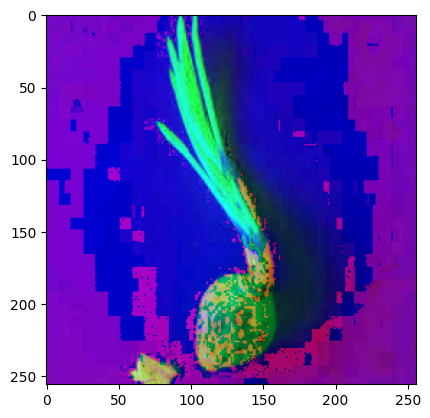

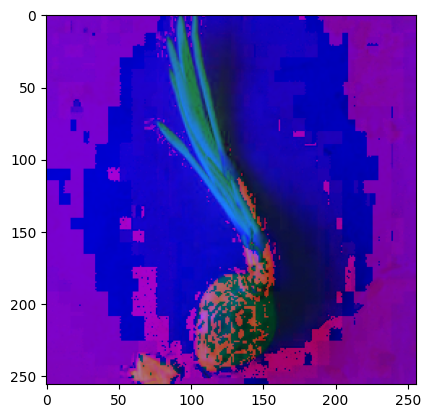

In [82]:
path = 'G:/Meine Ablage/KI_Projekt/Bilder/Internet/zwiebel_2.jpg'
vegi_BGR = cv2.imread(path) # As BGR
vegi_sq_BGR_original = resize_to_square(vegi_BGR) # BGR
vegi_hsv = cv2.cvtColor(vegi_sq_BGR_original, cv2.COLOR_BGR2HSV)
show_image_plt(vegi_hsv)

h, s, v = cv2.split(vegi_hsv)
s_new = s * 0.5
vegi_hsv_new = cv2.merge([h, np.uint8(s_new), v])
show_image_plt(vegi_hsv_new)

In [99]:
ms

[65.25103759765625,
 89.02412414550781,
 58.698028564453125,
 42.21745300292969,
 84.93119812011719,
 105.89103698730469,
 82.79180908203125,
 27.717147827148438]

In [96]:
ms

[30.286285400390625,
 26.145782470703125,
 32.08207702636719,
 41.182098388671875,
 47.92341613769531,
 35.91136169433594,
 30.538970947265625,
 35.97332763671875,
 28.52386474609375,
 43.41639709472656,
 24.25201416015625,
 24.673477172851562,
 25.825454711914062,
 25.724700927734375,
 36.104705810546875]

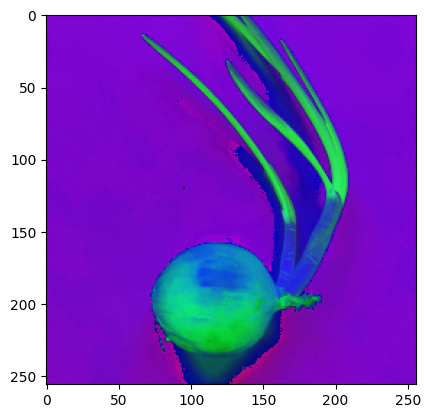

In [76]:
path = 'G:/Meine Ablage/KI_Projekt/Bilder/Zwiebel_Trieb/zwiebel_trieb_161.jpg'
vegi_BGR = cv2.imread(path) # As BGR
vegi_sq_BGR_original = resize_to_square(vegi_BGR) # BGR
vegi_hsv = cv2.cvtColor(vegi_sq_BGR_original, cv2.COLOR_BGR2HSV)
show_image_plt(vegi_hsv)

In [73]:
#vegis_df.to_csv("G:/Meine Ablage/KI_Projekt/Daten/.csv")

In [72]:
vegis_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1464 entries, 0 to 1463
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Hight               1464 non-null   int64  
 1   Width               1464 non-null   int64  
 2   R                   1464 non-null   uint8  
 3   G                   1464 non-null   uint8  
 4   B                   1464 non-null   uint8  
 5   green pixels        1464 non-null   int32  
 6   green onion pixels  1464 non-null   int32  
 7   ratio area          1464 non-null   float64
 8   circularity         1464 non-null   float64
 9   keypoints           1464 non-null   int64  
 10  mean keypoints      1464 non-null   float64
 11  Label               1464 non-null   object 
 12  Image               1464 non-null   object 
dtypes: float64(3), int32(2), int64(3), object(2), uint8(3)
memory usage: 118.7+ KB


In [60]:
len(keypoints)

42

In [61]:
keypoints[1].size
l = []
total = 0
for i, key in enumerate(keypoints):
    print(f"Index {i}: {key.size}")
    l.append(key.size)
    total += key.size
mean = total / len(keypoints)
mean

Index 0: 1.917380690574646
Index 1: 1.917380690574646
Index 2: 3.8274075984954834
Index 3: 2.4265401363372803
Index 4: 2.6355702877044678
Index 5: 3.1634931564331055
Index 6: 2.4623937606811523
Index 7: 2.5309438705444336
Index 8: 3.3708229064941406
Index 9: 4.123013019561768
Index 10: 5.0935821533203125
Index 11: 2.6240692138671875
Index 12: 2.0526673793792725
Index 13: 7.725550174713135
Index 14: 2.449420928955078
Index 15: 2.346459150314331
Index 16: 6.663586616516113
Index 17: 2.0272316932678223
Index 18: 2.0272316932678223
Index 19: 1.9373797178268433
Index 20: 3.5035297870635986
Index 21: 6.015287399291992
Index 22: 2.278878927230835
Index 23: 1.9758245944976807
Index 24: 6.379733085632324
Index 25: 5.338626384735107
Index 26: 66.25579833984375
Index 27: 9.768363952636719
Index 28: 4.889371871948242
Index 29: 4.889371871948242
Index 30: 4.889371871948242
Index 31: 1.890541672706604
Index 32: 2.815633535385132
Index 33: 2.6583731174468994
Index 34: 2.6583731174468994
Index 35: 3.3

5.227946735563732

In [59]:
biggest = max(l)
biggest

66.25579833984375